## QIB Email Analysis Notebook

### Imports

In [1]:
# Third-Party Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from pprint import pprint


# Local imports
from src.config.config import Config
from src.database.database import Database
from src.utils.data_exporter import DataExporter

### Database Connection

In [2]:
config = Config.from_json('config.json')
database = Database.from_credentials(username=config.db_user, password=config.db_password, host=config.db_host, database=config.db_name)
data_exporter = DataExporter(database)

### Retrieve Emails

In [3]:
dfs = data_exporter.to_dfs()
dfs.keys()

dict_keys(['folders', 'addresses', 'messages', 'recipients'])

In [4]:
folders = dfs['folders']
addresses = dfs['addresses']
messages = dfs['messages']
recipients = dfs['recipients']

In [5]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5039 entries, 1 to 5039
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   global_message_id     5039 non-null   object        
 1   folder_id             5039 non-null   int64         
 2   from_address_id       5039 non-null   int64         
 3   provider_email_id     5039 non-null   int64         
 4   creation_time         5039 non-null   datetime64[ns]
 5   submit_time           5039 non-null   datetime64[ns]
 6   delivery_time         5039 non-null   datetime64[ns]
 7   sender_name           5039 non-null   object        
 8   in_reply_to           587 non-null    object        
 9   subject               4923 non-null   object        
 10  plain_text_body       233 non-null    object        
 11  rich_text_body        16 non-null     object        
 12  html_body             4784 non-null   object        
 13  first_in_thread       5

## Preprocessing

Emails with whitespace only text bodies should count as na/Empty Emails

In [6]:
messages["plain_text_body"] = messages["plain_text_body"].apply(lambda x: None if pd.isna(x) or x.strip() == "" else x)

## Investigating Email Bodies

### Types of Email Bodies

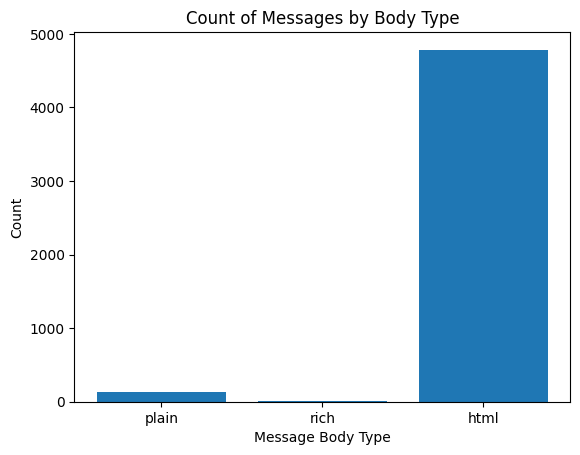

In [7]:
plain_text_body_count = messages['plain_text_body'].notna().sum()
rich_text_body_count = messages['rich_text_body'].notna().sum()
html_body_count = messages['html_body'].notna().sum()
data = [plain_text_body_count, rich_text_body_count, html_body_count]

plt.bar(['plain', 'rich', 'html'], data)
plt.xlabel('Message Body Type')
plt.ylabel('Count')
plt.title('Count of Messages by Body Type')
plt.show()

### Correlation Matrix of Message Body Types

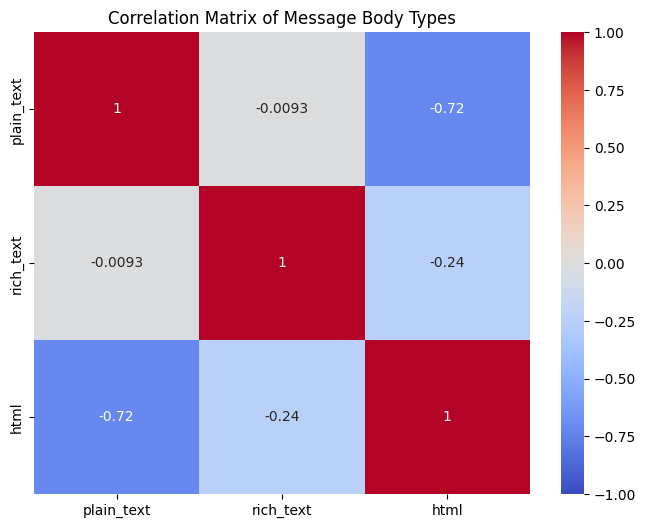

In [8]:
presence_df = pd.DataFrame({
    "plain_text": messages["plain_text_body"].notna(),
    "rich_text": messages["rich_text_body"].notna(),
    "html": messages["html_body"].notna()
})

correlation_matrix = presence_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Message Body Types")
plt.show()

### Sample Emails with only Plain Text Bodies

In [17]:
plain_text_body_values = messages[messages["plain_text_body"].notna()]["plain_text_body"]
print(plain_text_body_values.sample().item())

Hello Belal,

Thank you for contacting Parallels Support. 

Based on your email, we understand that you are unable to activate the Parallels Desktop.

We pulled the records and reset the activation key from our side. Now you can go ahead and try to activate now. 

Please feel free to contact us for any further assistance.

We appreciate your time and consideration. 

Thanks,
--
Shathish Anandan
Customer Support
|| Parallels

Knowledge base: http://kb.parallels.com
Follow us on Twitter: @ParallelsCares



### Sample Emails with only Rich Text Format Bodies

In [10]:
rich_text_body_values = messages[messages["rich_text_body"].notna()]["rich_text_body"]
rich_text_body_values.sample().item()

'{\\rtf1\\ansi\\ansicpg1252\\fromhtml1 \\fbidis \\deff0{\\fonttbl\r\n{\\f0\\fswiss\\fcharset0 Arial;}\r\n{\\f1\\fmodern Courier New;}\r\n{\\f2\\fnil\\fcharset2 Symbol;}\r\n{\\f3\\fmodern\\fcharset0 Courier New;}\r\n{\\f4\\fswiss "Calibri";}}\r\n{\\colortbl\\red0\\green0\\blue0;\\red5\\green99\\blue193;}\r\n\\uc1\\pard\\plain\\deftab360 \\f0\\fs24 \r\n{\\*\\htmltag19 <html xmlns:v="urn:schemas-microsoft-com:vml" xmlns:o="urn:schemas-microsoft-com:office:office" xmlns:w="urn:schemas-microsoft-com:office:word" xmlns:m="http://schemas.microsoft.com/office/2004/12/omml" xmlns="http://www.w3.org/TR/REC-html40">}\r\n{\\*\\htmltag2 \\par }\r\n{\\*\\htmltag34 <head>}\r\n{\\*\\htmltag1 \\par }\r\n{\\*\\htmltag1 \\par }\r\n{\\*\\htmltag161 <meta name="Generator" content="Microsoft Word 15 (filtered medium)">}\r\n{\\*\\htmltag1 \\par }\r\n{\\*\\htmltag241 <style>}\r\n{\\*\\htmltag241 <!--\\par /* Font Definitions */\\par @font-face\\par \\tab \\{font-family:"Cambria Math";\\par \\tab panose-1:2 4 

### Sample Emails with only HTML Bodies

In [ ]:
sample_message = messages.where(messages.html_body.notna()).sample()
display(HTML(sample_message.html_body.item()))

## Email Domain Investigation

### Bar Graph of Top Domains

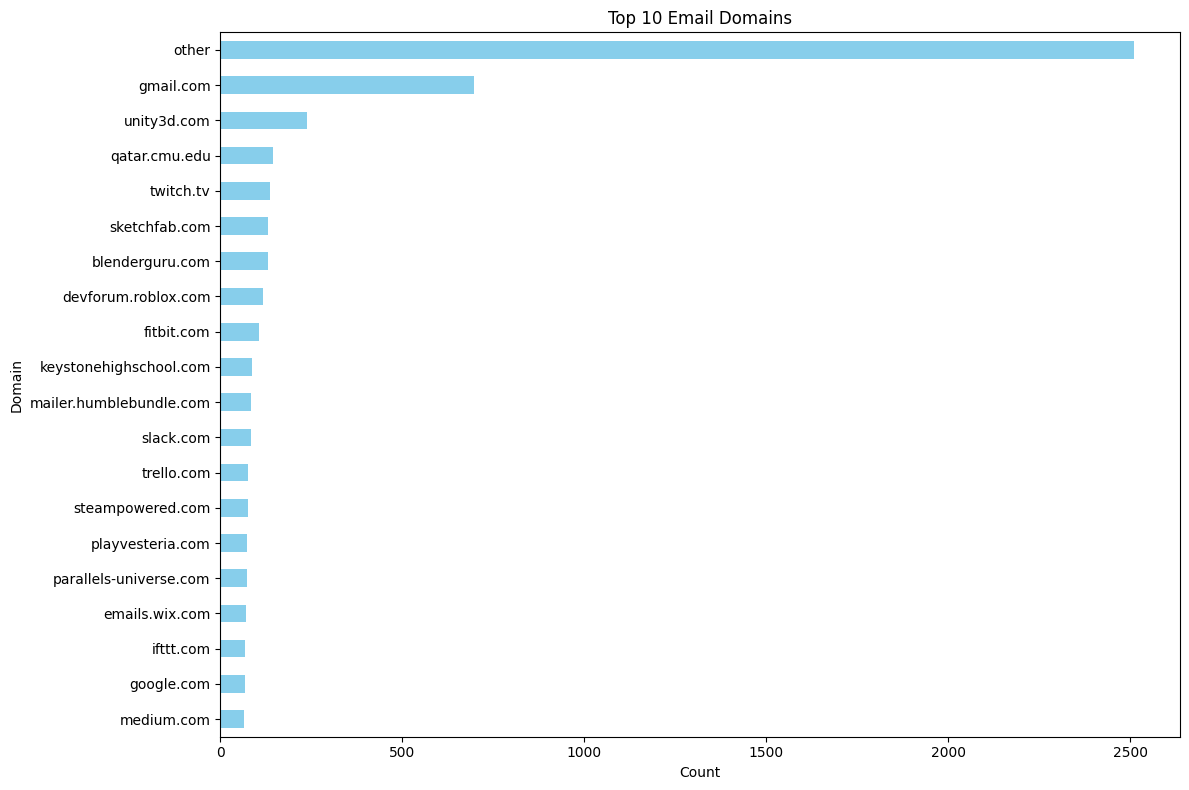

In [40]:
domain_counts = messages['domain'].value_counts()
top_domains = domain_counts.nlargest(19)
other_count = domain_counts[~domain_counts.index.isin(top_domains.index)].sum()
top_10_domains = pd.concat([top_domains, pd.Series({'other': other_count})])

plt.figure(figsize=(12, 8))
top_10_domains.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Email Domains')
plt.xlabel('Count')
plt.ylabel('Domain')
plt.tight_layout()

plt.show()
